This notebook (1) trains RNNs (7D or 60D) on the 2-back task. 7D networks have one-hot vectors as input and 60D networks have circular input; (2) visualizes RNN hidden layer activity using PCA; (3) tests networks on an independent testing set; (5) makes trials by concatenating every 2 adjacent stimulus events.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import random
import torch.utils.data as data_utils
from sklearn.decomposition import PCA
import scipy.io

In [ ]:
#load stimuli
%cd /content/gdrive/My Drive/RNN/
stim_all= torch.tensor(np.loadtxt("2backRNN_trainStim.txt")).float()
targets_all= torch.tensor(np.loadtxt("2backRNN_trainTarget.txt")).float()

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, n_hidden, n_layer):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, n_hidden, n_layer)
        self.out = nn.Linear(n_hidden, 1)
    def forward(self, input):
        h, _ = self.lstm(input)
        y = self.out(torch.relu(h))
        return h, y.squeeze().transpose(dim0=1, dim1=0)

# Squared error loss function (MSE)
def loss_fn(outputs, targets): 
    acc = torch.zeros(outputs.size(0))
    total_err = torch.zeros(1)
    resp_tp = np.arange(6,n_timestep,3)
    n_resp = n_stim - 2

    for i in range(outputs.size(0)): #batch
        batch_err = torch.zeros(1)
        batch_acc = 0

        for j in resp_tp: #timepoints
            batch_err += (targets[i,j] - outputs[i,j])**2/n_resp
            err = (targets[i,j] - outputs[i,j]).detach().numpy()
            if np.absolute(err) < 0.5:
                batch_acc += 1/n_resp
        total_err += batch_err
        acc[i] = batch_acc
    return total_err, acc

In [ ]:
# Train LSTM
circular = False 
#if True train 60D RNN with circular input,
#else 7D RNN with discrete input

batch_size = 20
n_layer = 1
n_stim = 20
n_timestep = 58
learning_rate = 1e-3
n_sequence = 200
if circular is True:
  n_hidden = 60
  n_iter = 1500 # iterations of SGD
  input_size = 2
else:
  n_hidden = 7
  n_iter = 5000
  input_size = 6

track_loss = np.zeros(n_iter)
model2 = LSTM(input_size, n_hidden, n_layer)
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
np.random.seed()

# Loop over iterations
t = 0
for i in range(n_iter):
    if (i + 1) %  100 == 0: # print progress every 100 iterations
        print('%.2f%% iterations of Adam completed...loss = %.2f'  % (100* (i + 1) / n_iter, loss*10))
    input_mat = torch.zeros(n_timestep,batch_size, input_size)
    batch_idx = np.random.choice(n_sequence, batch_size)
    stim, targets = stim_all[batch_idx,:], targets_all[batch_idx,:]

    for i in range(batch_size):
        for j in range(n_timestep):
            if (j+1)%3==1:
              if circular is True:
                angle = (int(stim[i,j])*30 + 10)*np.pi/180 #corresponding to orientation angle
                input_mat[j,i,0] = np.cos(2 * angle)
                input_mat[j,i,1] = np.sin(2 * angle) 
              else:
                input_mat[j,i,int(stim[i,j])] = 1  #activate the stimulus unit

    hidden, outputs = model2.forward(input_mat)  #LSTM model
    loss, acc = loss_fn(outputs, targets)
    track_loss[t] = loss 
   # Compute gradients
    optimizer.zero_grad()
    loss.backward()
   # Update weights
    optimizer.step()
    t += 1

In [ ]:
print(acc)
print(sum(acc)/20)
plt.plot(track_loss)

In [ ]:
# #Instead of training new networks, we can load old networks
# circular = False
# input_size = 6
# n_hidden =  7
# batch_size = 20
# n_layer = 1
# n_stim = 20
# model2 = LSTM(input_size, n_hidden, n_layer)
# model2.load_state_dict(torch.load(f'/content/gdrive/My Drive/RNN/2Bonly_7units_7.pt'))
# model2.eval()

In [ ]:
# feed the whole training set into network to extract hidden layer activity
n_timestep = 58
n_sequence = 200
stim, targets = stim_all, targets_all
batch_size = n_sequence
input_mat = torch.zeros(n_timestep, batch_size, input_size)

for i in range(batch_size):
      for j in range(n_timestep):
          if (j+1)%3==1:
            if circular is True:
              angle = (int(stim[i,j])*30 + 10)*np.pi/180 #corresponding to orientation angle
              input_mat[j,i,0] = np.cos(2 * angle)
              input_mat[j,i,1] = np.sin(2 * angle) 
            else:
              input_mat[j,i,int(stim[i,j])] = 1  #activate the stimulus unit
              
hidden, outputs = model2.forward(input_mat)
loss, acc = loss_fn(outputs, targets)

print(loss)
print(acc)
print(sum(acc)/200)

In [ ]:
#save trained network
torch.save(model2.state_dict(), "/content/gdrive/My Drive/RNN/2Bonly_7units_1.pt") #add circ_ if 60D RNN

In [ ]:
#save hidden layer activty for processing
import scipy.io

input_mats = input_mat.detach().numpy()
hidden_mats = hidden.detach().numpy()
output_mats = outputs.detach().numpy()

scipy.io.savemat('/content/gdrive/My Drive/RNN/2Bonly_7units_1.mat', mdict={'input': input_mats, 'hidden': hidden_mats, 'output':output_mats})

# PCA visualization of hidden layer activity

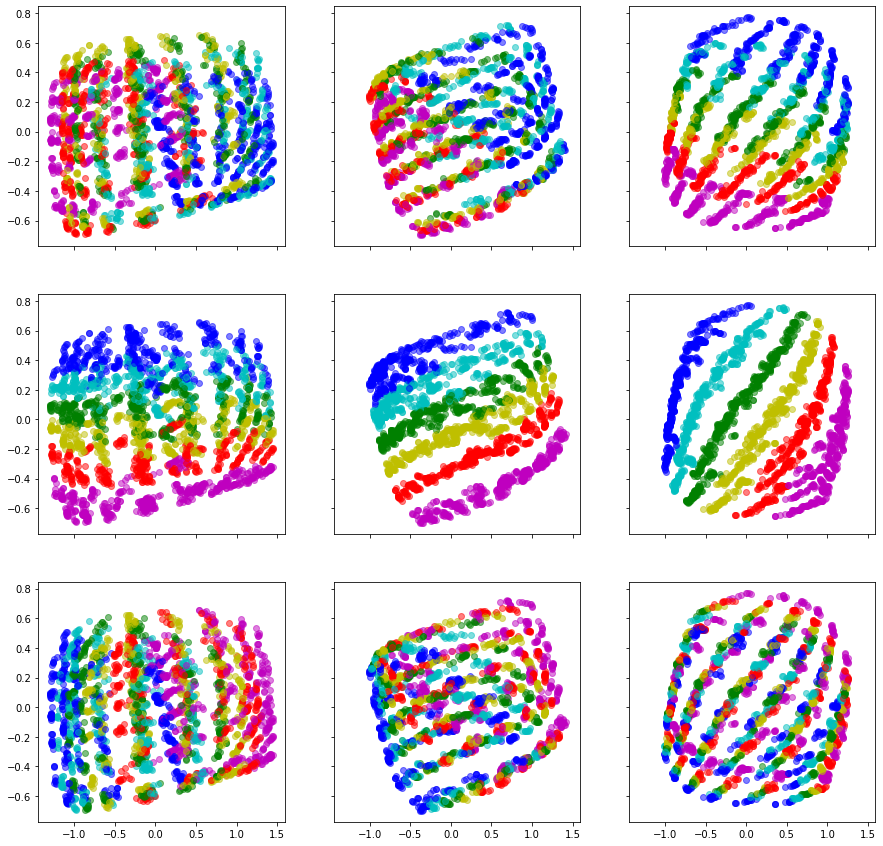

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(3*5, 3*5), sharex=True, sharey=True)

# Set up PCA
pca = PCA(n_components=2) # reduce dimensionality to 2

# Choose digits whose representations to plot and colors to plot them with
plot_digits = [0,1,2,3,4,5]
plot_colors = ['r', 'b', 'g','y', 'm', 'c']

# Do PCA on activations, and plot the dimensionality-reduced activations
hid_2d = np.reshape(hidden.transpose(dim0=1,dim1=0).detach().numpy(), (-1, n_hidden))
stim_2d = np.reshape(stim.detach().numpy(),(-1))
pc_activity = pca.fit_transform(hid_2d) 

for t_move in range(9):
    tp0 = np.arange(6,51,3) + t_move
    for bnum in range(batch_size):
        if bnum == 0:
            tps = tp0
        else:
            tps = np.concatenate((tps, tp0 + 58*bnum))

    for indx in tps:
        label = stim_2d[indx-t_move]
        for digit, color in zip(plot_digits, plot_colors):
            if label == digit:
                x, y = pc_activity[indx, 0], pc_activity[indx, 1]
                n = pc_activity.shape[0]
                if t_move < 3:
                    axs[0,t_move].plot(x, y, 'o', color=color, alpha=0.5)
                elif t_move < 6:
                    axs[1,t_move-3].plot(x, y, 'o', color=color, alpha=0.5)
                else:
                    axs[2,t_move-6].plot(x, y, 'o', color=color, alpha=0.5)
  #following example is from 7-unit network #7

# Test networks with testing set

In [ ]:
#load test data
%cd /content/gdrive/My Drive/RNN/
stim_all= torch.tensor(np.loadtxt("2B_test_200_stim.txt")).float()
targets_all= torch.tensor(np.loadtxt("2B_test_200_targ.txt")).float()

In [ ]:
#load saved model
circular = False
inet = 10 #which network
batch_size = 20
n_layer = 1
n_stim = 20
n_timestep = 58
n_sequence = 200
if circular is True:
  n_hidden = 60
  input_size = 2
else:
  n_hidden = 7
  input_size = 6

model2 = LSTM(input_size, n_hidden, n_layer)
model2.load_state_dict(torch.load(f'/content/gdrive/My Drive/RNN/2Bonly_{n_hidden}units_{inet}.pt')) #add circ_ before {inet} if 60D RNNs
model2.eval()

#test network (with new test stim)
n_timestep = 58
n_sequence = 200
stim, targets = stim_all, targets_all
batch_size = n_sequence
input_mat = torch.zeros(n_timestep, batch_size, input_size)

for i in range(batch_size):
      for j in range(n_timestep):
          if (j+1)%3==1:
            if circular is True:
              angle = (int(stim[i,j])*30 + 10)*np.pi/180 #corresponding to orientation angle
              input_mat[j,i,0] = np.cos(2 * angle)
              input_mat[j,i,1] = np.sin(2 * angle) 
            else:
              input_mat[j,i,int(stim[i,j])] = 1  #activate the stimulus unit
hidden, outputs = model2.forward(input_mat)
loss, acc = loss_fn(outputs, targets)
print(loss)
print(acc)
print(sum(acc)/batch_size)

# Make trials (concatenate every 2 stimulus events)

In [ ]:
# reformat the downloaded data from trained RNN:
# EEG_data (num_unit x 6 x 200*(18-3+1))
# orimat (200*(18-3+1) x 2) 
# respmat (200*(18-3+1) x 2)

%cd /content/gdrive/My Drive/RNN

circular = False
num_sub = 1
num_unit = 7

train_dat = scipy.io.loadmat(f'/content/gdrive/My Drive/RNN/2backRNN_trainStim.mat')
stim = train_dat['stim']
target = train_dat['target']

for sub in range(num_sub):
    subject_id = sub + 1
    EEG_data = np.zeros((num_unit,6,200*(18-2))) #remove first 2 trials
    orimat = np.zeros((200*(18-2), 2))
    respmat = np.zeros((200*(18-2), 2))
    
    data = scipy.io.loadmat(f'/content/gdrive/My Drive/RNN/2Bonly_{num_unit}units_{subject_id}.mat') #add circ_ before {subject_id} if 60D RNNs
    input = data['input'] 
    hidden = data['hidden'] 
    output = data['output']
    
    t = 0 
    for block in range(200):
        for trial in np.arange(2,18):

            EEG_data[:,:,t] = np.squeeze(hidden[trial*3  : trial*3+6, block, :]).T
            orimat[t,:] = np.array([stim[block,trial*3], stim[block,trial*3+3]])+1

            #temporary
            resp_tmp = np.array([target[block,trial*3], target[block,trial*3+3]])
            resp_tmp[resp_tmp == 0] = 2
            respmat[t,:] = resp_tmp
            
            t = t + 1
    scipy.io.savemat(f'/content/gdrive/My Drive/data/2Bonly_{num_unit}units_2tr/2Bonly_{num_unit}units_2tr_{subject_id}.mat', mdict={'EEG_data': EEG_data, 'orimat': orimat, 'respmat':respmat})
   # change file and folder name accordingly (60D or 7D)